# Graded quiz. Параметрические критерии

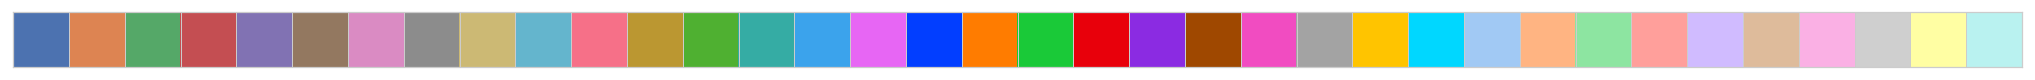

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
from statsmodels.stats import weightstats as wsts
from statsmodels.stats.proportion import proportion_confint
from sklearn import model_selection as mdsel
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)
        
def r4(*kargs):
    return [round(x, 4) for x in kargs] if len(kargs) > 1 else round(kargs[0], 4)

def r4s(a):
    return r4(*a)

## 03. Question 3

В одном из выпусков программы "Разрушители легенд" проверялось, действительно ли заразительна зевота. В эксперименте участвовало 50 испытуемых, проходивших собеседование на программу. Каждый из них разговаривал с рекрутером; в конце 34 из 50 бесед рекрутер зевал. Затем испытуемых просили подождать решения рекрутера в соседней пустой комнате.

Во время ожидания 10 из 34 испытуемых экспериментальной группы и 4 из 16 испытуемых контрольной начали зевать. Таким образом, разница в доле зевающих людей в этих двух группах составила примерно 4.4%. Ведущие заключили, что миф о заразительности зевоты подтверждён.

Можно ли утверждать, что доли зевающих в контрольной и экспериментальной группах отличаются статистически значимо? Посчитайте достигаемый уровень значимости при альтернативе заразительности зевоты, округлите до четырёх знаков после десятичной точки.

In [49]:
def proportions_diff_z_stat_ind(n1, n2, k1, k2):
    p1 = float(k1) / n1
    p2 = float(k2) / n2
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized: should be 'two-sided', 'less' or 'greater'")

    if alternative == 'two-sided':
        return 2 * (1 - sts.norm.cdf(np.abs(z_stat)))

    if alternative == 'less':
        return sts.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sts.norm.cdf(z_stat)

# independent samples
n1 = 34
n2 = 16

k1 = 10
k2 = 4

print r4(z_test(proportions_diff_z_stat_ind(n1, n2, k1, k2), 'greater'))

0.3729


## 04. Question 4
Имеются данные измерений двухсот швейцарских тысячефранковых банкнот, бывших в обращении в первой половине XX века. Сто из банкнот были настоящими, и сто — поддельными.

Отделите 50 случайных наблюдений в тестовую выборку с помощью функции sklearn.model_selection.train_test_split (зафиксируйте random state = 1). На оставшихся 150 настройте два классификатора поддельности банкнот:

- логистическая регрессия по признакам $X_1,X_2,X_3$
- логистическая регрессия по признакам $X_4,X_5,X_6$

Каждым из классификаторов сделайте предсказания меток классов на тестовой выборке. Одинаковы ли доли ошибочных предсказаний двух классификаторов? Проверьте гипотезу, вычислите достигаемый уровень значимости. Введите номер первой значащей цифры (например, если вы получили $5.5 \times 10^{-8}$, нужно ввести 8).

In [56]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def fit_predict(model, train, test, features, target):
    model.fit(train[features], train[target])
    return model.predict(test[features])

def proportions_diff_z_stat_rel(sample1, sample2):
    n = len(sample1)

    f = np.sum(np.logical_and(sample1 == 1, sample2 == 0))
    g = np.sum(np.logical_and(sample1 == 0, sample2 == 1))

    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

data = pd.read_csv('data/14_banknotes.txt', sep='\t')
data.sample()

train, test = mdsel.train_test_split(data, test_size=50, shuffle=True, random_state=1)

features1 = data.columns[:3]
features2 = data.columns[3:6]

pr1 = fit_predict(LogisticRegression(), train, test, features1, 'real')
pr2 = fit_predict(LogisticRegression(), train, test, features2, 'real')

print accuracy_score(pr1, test.real), accuracy_score(pr2, test.real)

epr1 = pr1 != test.real
epr2 = pr2 != test.real

p_value = z_test(proportions_diff_z_stat_rel(epr1, epr2))
# p_value = z_test(proportions_diff_z_stat_ind(n, n, sum(epr1), sum(epr2)))

print p_value
print int(np.ceil(-np.log10(p_value)))

0.8 0.98
0.0032969384555543435
3
Wall time: 41 ms


## 05. Question 5

В предыдущей задаче посчитайте 95% доверительный интервал для разности долей ошибок двух классификаторов. Чему равна его ближайшая к нулю граница? Округлите до четырёх знаков после десятичной точки.

In [58]:
def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = sts.norm.ppf(1 - alpha / 2.)
    n = len(sample1)

    f = np.sum(np.logical_and(sample1 == 1, sample2 == 0))
    g = np.sum(np.logical_and(sample1 == 0, sample2 == 1))

    boundary = z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)

    left_boundary = float(f - g) / n - boundary
    right_boundary = float(f - g) / n + boundary
    return (left_boundary, right_boundary)

def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):
    z = sts.norm.ppf(1 - alpha / 2.)
    n1 = len(sample1)
    n2 = len(sample2)

    p1 = float(sum(sample1)) / n1
    q1 = 1 - p1
    p2 = float(sum(sample2)) / n2
    q2 = 1 - p2
    normed_S = np.sqrt(p1 * q1 / n1 + p2 * q2 / n2)

    left_boundary = (p1 - p2) - z * normed_S
    right_boundary = (p1 - p2) + z * normed_S

    return (left_boundary, right_boundary)

confint = proportions_diff_confint_rel(epr1, epr2)
print r4(confint[0])

confint = proportions_diff_confint_ind(epr1, epr2)
print r4(confint[0])

0.0599
0.0625


## 06. Question 6

Ежегодно более 200000 людей по всему миру сдают стандартизированный экзамен GMAT при поступлении на программы MBA. Средний результат составляет 525 баллов, стандартное отклонение — 100 баллов.

Сто студентов закончили специальные подготовительные курсы и сдали экзамен. Средний полученный ими балл — 541.4. Проверьте гипотезу о неэффективности программы против односторонней альтернативы о том, что программа работает. Отвергается ли на уровне значимости 0.05 нулевая гипотеза? Введите достигаемый уровень значимости, округлённый до 4 знаков после десятичной точки.

In [47]:
# from 200000
mu = 525
sigma = 100

n = 100
avg = 541.4

print r4(z_test((avg - mu) / (sigma/np.sqrt(n)), 'greater'))

0.0505


## 07. Question 7

Оцените теперь эффективность подготовительных курсов, средний балл 100 выпускников которых равен 541.5. Отвергается ли на уровне значимости 0.05 та же самая нулевая гипотеза против той же самой альтернативы? Введите достигаемый уровень значимости, округлённый до 4 знаков после десятичной точки.

In [48]:
avg = 541.5
print r4(z_test((avg - mu) / (sigma/np.sqrt(n)), 'greater'))

0.0495
